<h1><center>Machine Learning and Asset Pricing Models</center></h1>
<h2><center>Yujia Ren yxr126@case.edu</center></h2>

<em>Statistical explanations are from scikit-learn website.</em>

<h2>Problem definition</h2>

In this project, I plan to use machine learning to construct an asset pricing model. In the model, I will have a set of variables to capture the features of stock returns. The problem naturally is categorized into two sub-tasks: the choice of the most important features and the prediction of the stock returns. We will separate our data into the training and testing sets, which are totally separated in the task. We will first train the data using all input variables available, then we select the most important k variables based on the prediction. Then we truncate the number variables to k to redo the prediction. To improve the robustness of our method, we will test our full-variable and truncated-variable models using the testing set, and apply four-fold cross-validation to run the model multiple times. Besides, according to the reference (Gu et al., 2019), we may use a new methodology here, which includes the statistical model describing the risk premium, an  objective function to estimate model parameters and computational algorithms. The methods we will use include but not limited to simple linear regression, regularized linear regressions (e.g. ridge regression), boosted regression tree, random forests and neural networks. For input space dimension reduction, we can use partial linear square (PLS) and principal component regression (PCR). All of the estimates share the basic goal of minimum MSE. The final result of this project includes the regression accuracy, the most important input variables of each method.

<h2>Import modules</h2>

In [1]:
# import modules
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
%matplotlib inline

## Define functions

In [2]:
def generate_data(sic2_number=1):
    '''
    A function to read the stock data and output standardized x and y
    args: sic2 stock code (i.e 1 means agricultural stocks)
    return: standardized x, y and column names
    '''
    # import feature and returns
    df = pd.read_csv(r'../yujia_data/data/project_machine.csv')
    column_names_old = list(df)
    df = df[df['sic2']==sic2_number]
    df = df.fillna(0)
    #df = df.dropna(axis=1)
    not_include = ['RET','DATE', 'permno', 'sic2', 'gvkey', 'fyear', 'datadate',
                   'rdq', 'ewret', 'DLRET', 'DLSTCD']
    x = df.drop(not_include, axis=1)
    column_names = [e for e in column_names_old if e not in not_include] 
    y = df['RET']
    
    # standardize the data
    
    min_max_scaler = MinMaxScaler()
    x = min_max_scaler.fit_transform(x)
    y = y.values

    return x, y, column_names

## Ordinary least squares regression
The following are a set of methods intended for regression in which the target value is expected to be a linear combination of the features. In mathematical notation, if $\hat{y}$ is the predicted value.

$$
\begin{aligned}
\hat{y}(w, x) = w_0 + w_1 x_1 + ... + w_p x_p
\end{aligned}
\\
$$

Across the module, we designate the vector $w = (w_1,
..., w_p)$ as <code>coef_</code> and $w_0$ as <code>intercept_</code>.

Ordinary Least Squares fits a linear model with coefficients $w = (w_1, ..., w_p)$ to to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Mathematically it solves a problem of the form:
$$
\begin{aligned}
\min_{w} || X w - y||_2^2
\end{aligned}
$$

In [3]:
def ols(x_train, x_test, y_train, y_test, alpha=None):
    '''
    A function to do ols regression
    args: x train, x test, y train, y test, dummpy alpha
    return: y pred, linear coefficients
    '''
    clf = LinearRegression()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    coef = clf.coef_.squeeze()
    return y_pred, coef

## Lasso regression
The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. For this reason Lasso and its variants are fundamental to the field of compressed sensing. Under certain conditions, it can recover the exact set of non-zero coefficients.

Mathematically, it consists of a linear model with an added regularization term. The objective function to minimize is:

$$
\begin{aligned}
\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}
\end{aligned}
$$

The lasso estimate thus solves the minimization of the least-squares penalty with $\alpha ||w||_1$ added, where $\alpha$ is a constant and $||w||_1$ is the $\ell_1$-norm of the coefficient vector.

In [4]:
def lasso(x_train, x_test, y_train, y_test, alpha=0.0001):
    '''
    A function to do lasso regression
    args: x train, x test, y train, y test, lasso alpha
    return: y pred, linear coefficients
    '''
    clf = Lasso(alpha=alpha, max_iter=10000)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    coef = clf.coef_.squeeze()
    return y_pred, coef

## Ridge regression

Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients. The ridge coefficients minimize a penalized residual sum of squares:

$$
\begin{aligned}
\min_{w} || X w - y||_2^2 + \alpha ||w||_2^2
\end{aligned}
$$

The complexity parameter $\alpha \geq 0$ controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity.

In [5]:
def ridge(x_train, x_test, y_train, y_test, alpha=0.2):
    '''
    A function to do ridge regression
    args: x train, x test, y train, y test, ridge alpha
    return: y pred, linear coefficients
    '''
    clf = Ridge(alpha=alpha, max_iter=10000)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    coef = clf.coef_.squeeze()
    return y_pred, coef

## Baytesian ridge regression

Bayesian regression techniques can be used to include regularization parameters in the estimation procedure: the regularization parameter is not set in a hard sense but tuned to the data at hand.

This can be done by introducing uninformative priors over the hyper parameters of the model. The $\ell_2$ regularization used in Ridge regression and classification is equivalent to finding a maximum a posteriori estimation under a Gaussian prior over the coefficients  with precision $\lambda^{-1}$. Instead of setting <code>lambda</code> manually, it is possible to treat it as a random variable to be estimated from the data.
    
To obtain a fully probabilistic model, the output $y$ is assumed to be Gaussian distributed around $Xw$:

$$
\begin{aligned}
p(y|X,w,\alpha) = \mathcal{N}(y|X w,\alpha)
\end{aligned}
$$

where $\alpha$ is again treated as a random variable that is to be estimated from the data.

The advantages of Bayesian Regression are:
* It adapts to the data at hand.
* It can be used to include regularization parameters in the estimation procedure.

The disadvantages of Bayesian regression include:
* Inference of the model can be time consuming.

BayesianRidge estimates a probabilistic model of the regression problem as described above. The prior for the coefficient  is given by a spherical Gaussian:

$$
\begin{aligned}
p(w|\lambda) =
\mathcal{N}(w|0,\lambda^{-1}\mathbf{I}_{p})
\end{aligned}
$$

The priors over $\alpha$ and $\lambda$ are chosen to be gamma distributions, the conjugate prior for the precision of the Gaussian. The resulting model is called <em>Bayesian Ridge Regression</em>, and is similar to the classical Ridge.

The parameters $w$, $\alpha$ and $\lambda$ are estimated jointly during the fit of the model, the regularization parameters $\alpha$ and $\lambda$ being estimated by maximizing the <em>log marginal likelihood</em>.

In [6]:
def bayesianridge(x_train, x_test, y_train, y_test, alpha=None):
    '''
    A function to do bayesian ridge regression
    args: x train, x test, y train, y test, dummy alpha
    return: y pred, linear coefficients
    '''
    clf = BayesianRidge(alpha_1=0.0001, alpha_2=0.0001)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    coef = clf.coef_.squeeze()
    return y_pred, coef

## Stochastic Gradient Descent

Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.

In [7]:
def sgdregressor(x_train, x_test, y_train, y_test, alpha=None):
    '''
    A function to do SGD regression
    args: x train, x test, y train, y test, dummy alpha
    return: y pred
    '''
    clf = SGDRegressor(penalty='l1')
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    coef = clf.coef_.squeeze()
    return y_pred, coef

## Decision Tree

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [8]:
def decisiontree(x_train, x_test, y_train, y_test, alpha=None):
    '''
    A function to do dicition tree regression
    args: x train, x test, y train, y test, dummy alpha
    return: y pred
    '''
    clf = DecisionTreeRegressor()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    return y_pred, 0

In [9]:
def k_fold(x, y, n_splits=4):
    '''
    A function to do k-fold cross-validation
    args: x, y, number of splits
    return: x train, x test, y_train, y test lists
    '''
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    kf.get_n_splits(x)
    x_trains, x_tests, y_trains, y_tests = [], [], [], []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        x_trains.append(x_train)
        x_tests.append(x_test)
        y_trains.append(y_train)
        y_tests.append(y_test)
    return x_trains, x_tests, y_trains, y_tests

In [10]:
def plot_pred(y_test, y_pred, title):
    '''
    A function to plot the actual and predicted stock return
    args: actual return, predicted return, type of regression
    return: save an image
    '''
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual return')
    plt.ylabel('Predicted return')
    plt.grid()
    plt.savefig('./plots/{}.svg'.format(title), dpi=400)
    plt.show();

In [11]:
def evaluation(x, y, metric, alpha):
    x_trains, x_tests, y_trains, y_tests = k_fold(x, y, n_splits=4)
    y_true = []
    y_pred = []
    for i in range(len(x_trains)):
        x_train = x_trains[i]
        x_test = x_tests[i]
        y_train = y_trains[i]
        y_test = y_tests[i]
        y_pred.append(metric(x_train, x_test, y_train, y_test, alpha)[0])
        y_true.append(y_tests[i])
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    # evaluation
    plot_pred(y_true, y_pred, metric.__name__)
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**0.5
    print('R2: {:.4f}'.format(r2))
    print('RMSE: {:.4f}'.format(rmse))
    return

In [12]:
x, y, column_names = generate_data(sic2_number=1)

## Evaludation with full variables

### OLS

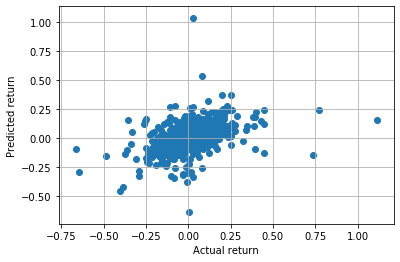

R2: 0.0725
RMSE: 0.1204


In [13]:
evaluation(x, y, metric=ols, alpha=None)

### Ridge

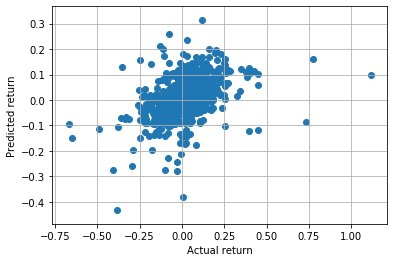

R2: 0.1678
RMSE: 0.1141


In [14]:
evaluation(x, y, metric=ridge, alpha=0.2)

### Lasso

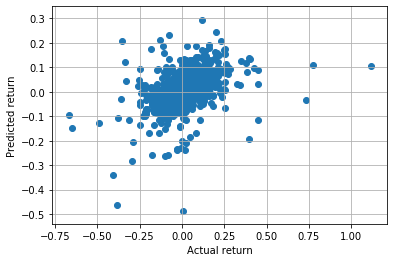

R2: 0.1678
RMSE: 0.1141


In [15]:
evaluation(x, y, metric=lasso, alpha=0.0001)

### Bayesian Ridge Regression

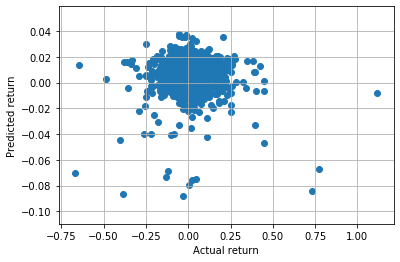

R2: -0.0183
RMSE: 0.1262


In [16]:
evaluation(x, y, metric=bayesianridge, alpha=None)

### Stochastic Gradient Descent

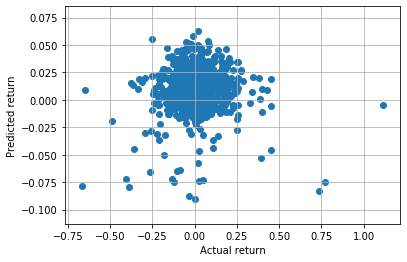

R2: -0.0176
RMSE: 0.1262


In [17]:
evaluation(x, y, metric=sgdregressor, alpha=None)

### Decision Tree

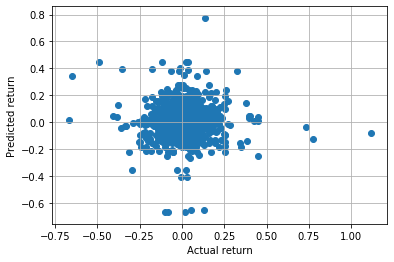

R2: -0.9547
RMSE: 0.1748


In [18]:
evaluation(x, y, metric=decisiontree, alpha=None)

## Removing features with low variance

VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by

$$
\begin{aligned}
\mathrm{Var}[X] = p(1 - p)
\end{aligned}
$$

so we can select using the threshold <code>$0.8 * (1-0.8)$</code>.

In [19]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(.99 * (1 - .99))
x_vt = sel.fit_transform(x)

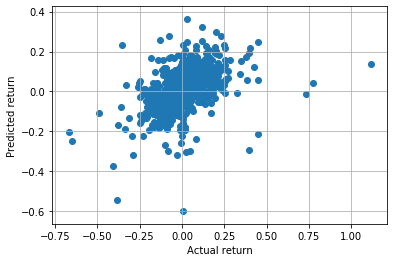

R2: 0.1425
RMSE: 0.1158


In [20]:
evaluation(x_vt, y, metric=ols, alpha=None)

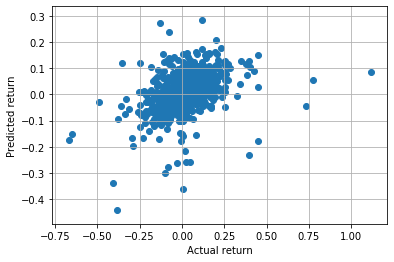

R2: 0.1478
RMSE: 0.1154


In [21]:
evaluation(x_vt, y, metric=ridge, alpha=0.2)

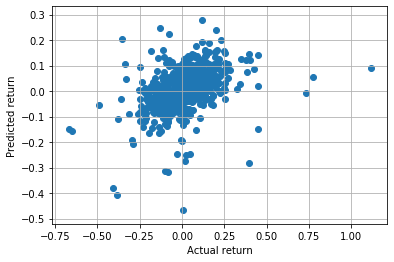

R2: 0.1518
RMSE: 0.1152


In [22]:
evaluation(x_vt, y, metric=lasso, alpha=0.0001)

## Recursive feature elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a <code>coef_</code> attribute or through a <code>feature_importances_</code> attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

RFECV performs RFE in a cross-validation loop to find the optimal number of features.

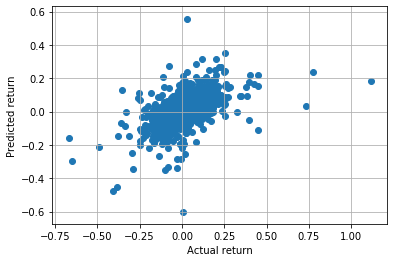

R2: 0.2573
RMSE: 0.1078


In [23]:
from sklearn.feature_selection import RFE
rfe_estimator = LinearRegression()
rfe = RFE(estimator=rfe_estimator, n_features_to_select=90, step=1)
rfe.fit(x, y)
ranking = rfe.ranking_
select = rfe.support_
x_rfe = x[:, select]
evaluation(x_rfe, y, metric=ols, alpha=None)

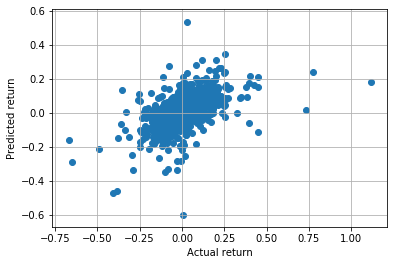

R2: 0.2581
RMSE: 0.1077


In [24]:
evaluation(x_rfe, y, metric=ridge, alpha=0.001)

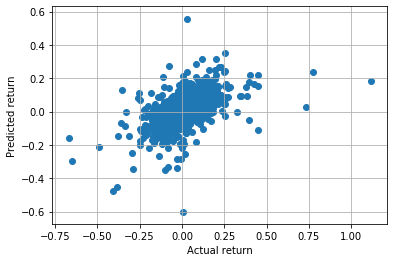

R2: 0.2573
RMSE: 0.1078


In [25]:
evaluation(x_rfe, y, metric=lasso, alpha=1e-8)

### Principal Component Analysis

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

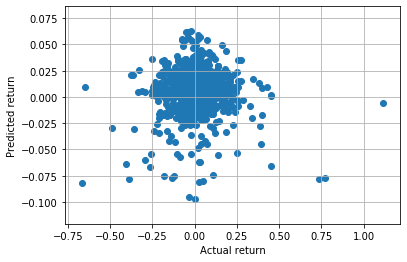

R2: -0.0283
RMSE: 0.1268


In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(x)
x_pca = pca.fit_transform(x)
evaluation(x_pca, y, metric=ols, alpha=None)

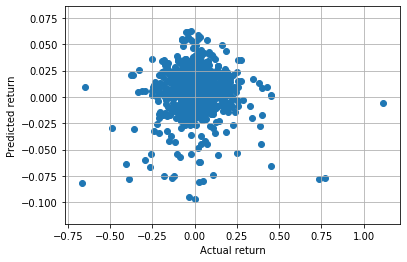

R2: -0.0282
RMSE: 0.1268


In [27]:
evaluation(x_pca, y, metric=ridge, alpha=0.2)

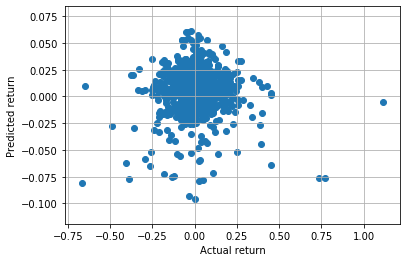

R2: -0.0270
RMSE: 0.1267


In [28]:
evaluation(x_pca, y, metric=lasso, alpha=0.0001)

## Neural Network

Train on 366 samples, validate on 366 samples
Epoch 1/20000
366/366 [==============================] - 3s 8ms/step - loss: 7.8705 - mean_absolute_error: 7.8705 - val_loss: 8.9300 - val_mean_absolute_error: 8.9300
Epoch 2/20000
366/366 [==============================] - 0s 18us/step - loss: 7.7682 - mean_absolute_error: 7.7682 - val_loss: 15.3916 - val_mean_absolute_error: 15.3916
Epoch 3/20000
366/366 [==============================] - 0s 20us/step - loss: 7.6225 - mean_absolute_error: 7.6225 - val_loss: 13.4672 - val_mean_absolute_error: 13.4672
Epoch 4/20000
366/366 [==============================] - 0s 25us/step - loss: 7.4173 - mean_absolute_error: 7.4173 - val_loss: 12.2986 - val_mean_absolute_error: 12.2986
Epoch 5/20000
366/366 [==============================] - 0s 23us/step - loss: 7.3671 - mean_absolute_error: 7.3671 - val_loss: 12.9951 - val_mean_absolute_error: 12.9951
Epoch 6/20000
366/366 [==============================] - 0s 25us/step - loss: 7.2521 - mean_absolute_error:

Epoch 49/20000
366/366 [==============================] - 0s 19us/step - loss: 5.5340 - mean_absolute_error: 5.5340 - val_loss: 20.1494 - val_mean_absolute_error: 20.1494
Epoch 50/20000
366/366 [==============================] - 0s 22us/step - loss: 5.3914 - mean_absolute_error: 5.3914 - val_loss: 17.3778 - val_mean_absolute_error: 17.3778
Epoch 51/20000
366/366 [==============================] - 0s 22us/step - loss: 5.4308 - mean_absolute_error: 5.4308 - val_loss: 17.7107 - val_mean_absolute_error: 17.7107
Epoch 52/20000
366/366 [==============================] - 0s 21us/step - loss: 5.6212 - mean_absolute_error: 5.6212 - val_loss: 15.8118 - val_mean_absolute_error: 15.8118
Epoch 53/20000
366/366 [==============================] - 0s 19us/step - loss: 5.4024 - mean_absolute_error: 5.4024 - val_loss: 15.1110 - val_mean_absolute_error: 15.1110
Epoch 54/20000
366/366 [==============================] - 0s 19us/step - loss: 5.4656 - mean_absolute_error: 5.4656 - val_loss: 15.3731 - val_mea

Epoch 97/20000
366/366 [==============================] - 0s 17us/step - loss: 4.1636 - mean_absolute_error: 4.1636 - val_loss: 27.2528 - val_mean_absolute_error: 27.2528
Epoch 98/20000
366/366 [==============================] - 0s 18us/step - loss: 4.4878 - mean_absolute_error: 4.4878 - val_loss: 27.6505 - val_mean_absolute_error: 27.6505
Epoch 99/20000
366/366 [==============================] - 0s 20us/step - loss: 4.1807 - mean_absolute_error: 4.1807 - val_loss: 27.9887 - val_mean_absolute_error: 27.9887
Epoch 100/20000
366/366 [==============================] - 0s 17us/step - loss: 4.0739 - mean_absolute_error: 4.0739 - val_loss: 23.5698 - val_mean_absolute_error: 23.5698
Epoch 101/20000
366/366 [==============================] - 0s 20us/step - loss: 4.2446 - mean_absolute_error: 4.2446 - val_loss: 28.7378 - val_mean_absolute_error: 28.7378
Epoch 102/20000
366/366 [==============================] - 0s 19us/step - loss: 4.0619 - mean_absolute_error: 4.0619 - val_loss: 36.5515 - val_

Epoch 145/20000
366/366 [==============================] - 0s 23us/step - loss: 3.3224 - mean_absolute_error: 3.3224 - val_loss: 22.7752 - val_mean_absolute_error: 22.7752
Epoch 146/20000
366/366 [==============================] - 0s 20us/step - loss: 3.6508 - mean_absolute_error: 3.6508 - val_loss: 22.8706 - val_mean_absolute_error: 22.8706
Epoch 147/20000
366/366 [==============================] - 0s 24us/step - loss: 3.2719 - mean_absolute_error: 3.2719 - val_loss: 23.6032 - val_mean_absolute_error: 23.6032
Epoch 148/20000
366/366 [==============================] - 0s 21us/step - loss: 3.4869 - mean_absolute_error: 3.4869 - val_loss: 22.7635 - val_mean_absolute_error: 22.7635
Epoch 149/20000
366/366 [==============================] - 0s 22us/step - loss: 3.2202 - mean_absolute_error: 3.2202 - val_loss: 21.7623 - val_mean_absolute_error: 21.7623
Epoch 150/20000
366/366 [==============================] - 0s 20us/step - loss: 3.1763 - mean_absolute_error: 3.1763 - val_loss: 21.7941 - v

Epoch 193/20000
366/366 [==============================] - 0s 15us/step - loss: 2.0431 - mean_absolute_error: 2.0431 - val_loss: 28.2672 - val_mean_absolute_error: 28.2672
Epoch 194/20000
366/366 [==============================] - 0s 17us/step - loss: 2.3866 - mean_absolute_error: 2.3866 - val_loss: 28.5586 - val_mean_absolute_error: 28.5586
Epoch 195/20000
366/366 [==============================] - 0s 19us/step - loss: 2.0157 - mean_absolute_error: 2.0157 - val_loss: 29.3114 - val_mean_absolute_error: 29.3114
Epoch 196/20000
366/366 [==============================] - 0s 17us/step - loss: 2.0732 - mean_absolute_error: 2.0732 - val_loss: 29.2879 - val_mean_absolute_error: 29.2879
Epoch 197/20000
366/366 [==============================] - 0s 16us/step - loss: 1.9127 - mean_absolute_error: 1.9127 - val_loss: 29.1810 - val_mean_absolute_error: 29.1810
Epoch 198/20000
366/366 [==============================] - 0s 17us/step - loss: 1.9019 - mean_absolute_error: 1.9019 - val_loss: 28.5863 - v

Epoch 40/20000
366/366 [==============================] - 0s 17us/step - loss: 5.9537 - mean_absolute_error: 5.9537 - val_loss: 11.5427 - val_mean_absolute_error: 11.5427
Epoch 41/20000
366/366 [==============================] - 0s 18us/step - loss: 5.7934 - mean_absolute_error: 5.7934 - val_loss: 11.2844 - val_mean_absolute_error: 11.2844
Epoch 42/20000
366/366 [==============================] - 0s 17us/step - loss: 5.7822 - mean_absolute_error: 5.7822 - val_loss: 11.6352 - val_mean_absolute_error: 11.6352
Epoch 43/20000
366/366 [==============================] - 0s 18us/step - loss: 5.7060 - mean_absolute_error: 5.7060 - val_loss: 11.5603 - val_mean_absolute_error: 11.5603
Epoch 44/20000
366/366 [==============================] - 0s 20us/step - loss: 5.6435 - mean_absolute_error: 5.6435 - val_loss: 12.0304 - val_mean_absolute_error: 12.0304
Epoch 45/20000
366/366 [==============================] - 0s 20us/step - loss: 5.6037 - mean_absolute_error: 5.6037 - val_loss: 13.6364 - val_mea

Epoch 88/20000
366/366 [==============================] - 0s 20us/step - loss: 4.3983 - mean_absolute_error: 4.3983 - val_loss: 19.5955 - val_mean_absolute_error: 19.5955
Epoch 89/20000
366/366 [==============================] - 0s 18us/step - loss: 4.0311 - mean_absolute_error: 4.0311 - val_loss: 17.7760 - val_mean_absolute_error: 17.7760
Epoch 90/20000
366/366 [==============================] - 0s 23us/step - loss: 4.3054 - mean_absolute_error: 4.3054 - val_loss: 21.3443 - val_mean_absolute_error: 21.3443
Epoch 91/20000
366/366 [==============================] - 0s 17us/step - loss: 4.3615 - mean_absolute_error: 4.3615 - val_loss: 24.0237 - val_mean_absolute_error: 24.0237
Epoch 92/20000
366/366 [==============================] - 0s 20us/step - loss: 4.1016 - mean_absolute_error: 4.1016 - val_loss: 23.9999 - val_mean_absolute_error: 23.9999
Epoch 93/20000
366/366 [==============================] - 0s 19us/step - loss: 4.0750 - mean_absolute_error: 4.0750 - val_loss: 23.5798 - val_mea

Epoch 136/20000
366/366 [==============================] - 0s 23us/step - loss: 3.4937 - mean_absolute_error: 3.4937 - val_loss: 36.5674 - val_mean_absolute_error: 36.5674
Epoch 137/20000
366/366 [==============================] - 0s 17us/step - loss: 3.4068 - mean_absolute_error: 3.4068 - val_loss: 38.3859 - val_mean_absolute_error: 38.3859
Epoch 138/20000
366/366 [==============================] - 0s 16us/step - loss: 3.6099 - mean_absolute_error: 3.6099 - val_loss: 35.2605 - val_mean_absolute_error: 35.2605
Epoch 139/20000
366/366 [==============================] - 0s 25us/step - loss: 3.4012 - mean_absolute_error: 3.4012 - val_loss: 35.8427 - val_mean_absolute_error: 35.8427
Epoch 140/20000
366/366 [==============================] - 0s 16us/step - loss: 3.5005 - mean_absolute_error: 3.5005 - val_loss: 36.1185 - val_mean_absolute_error: 36.1185
Epoch 141/20000
366/366 [==============================] - 0s 20us/step - loss: 3.2375 - mean_absolute_error: 3.2375 - val_loss: 37.0670 - v

Epoch 184/20000
366/366 [==============================] - 0s 19us/step - loss: 2.8729 - mean_absolute_error: 2.8729 - val_loss: 39.5101 - val_mean_absolute_error: 39.5101
Epoch 185/20000
366/366 [==============================] - 0s 17us/step - loss: 2.9956 - mean_absolute_error: 2.9956 - val_loss: 41.2640 - val_mean_absolute_error: 41.2640
Epoch 186/20000
366/366 [==============================] - 0s 19us/step - loss: 2.4024 - mean_absolute_error: 2.4024 - val_loss: 37.7934 - val_mean_absolute_error: 37.7934
Epoch 187/20000
366/366 [==============================] - 0s 17us/step - loss: 3.0295 - mean_absolute_error: 3.0295 - val_loss: 36.6684 - val_mean_absolute_error: 36.6684
Epoch 188/20000
366/366 [==============================] - 0s 19us/step - loss: 2.6855 - mean_absolute_error: 2.6855 - val_loss: 39.8662 - val_mean_absolute_error: 39.8662
Epoch 189/20000
366/366 [==============================] - 0s 20us/step - loss: 2.5285 - mean_absolute_error: 2.5285 - val_loss: 38.3262 - v

Epoch 30/20000
366/366 [==============================] - 0s 16us/step - loss: 6.3017 - mean_absolute_error: 6.3017 - val_loss: 11.4995 - val_mean_absolute_error: 11.4995
Epoch 31/20000
366/366 [==============================] - 0s 20us/step - loss: 6.2350 - mean_absolute_error: 6.2350 - val_loss: 11.6750 - val_mean_absolute_error: 11.6750
Epoch 32/20000
366/366 [==============================] - 0s 19us/step - loss: 6.2264 - mean_absolute_error: 6.2264 - val_loss: 11.5347 - val_mean_absolute_error: 11.5347
Epoch 33/20000
366/366 [==============================] - 0s 16us/step - loss: 6.1626 - mean_absolute_error: 6.1626 - val_loss: 11.5759 - val_mean_absolute_error: 11.5759
Epoch 34/20000
366/366 [==============================] - 0s 18us/step - loss: 6.1254 - mean_absolute_error: 6.1254 - val_loss: 11.8003 - val_mean_absolute_error: 11.8003
Epoch 35/20000
366/366 [==============================] - 0s 20us/step - loss: 6.1150 - mean_absolute_error: 6.1150 - val_loss: 11.7243 - val_mea

Epoch 78/20000
366/366 [==============================] - 0s 21us/step - loss: 4.6435 - mean_absolute_error: 4.6435 - val_loss: 21.0175 - val_mean_absolute_error: 21.0175
Epoch 79/20000
366/366 [==============================] - 0s 20us/step - loss: 4.5834 - mean_absolute_error: 4.5834 - val_loss: 17.6513 - val_mean_absolute_error: 17.6513
Epoch 80/20000
366/366 [==============================] - 0s 20us/step - loss: 4.6792 - mean_absolute_error: 4.6792 - val_loss: 16.5380 - val_mean_absolute_error: 16.5380
Epoch 81/20000
366/366 [==============================] - 0s 19us/step - loss: 4.7960 - mean_absolute_error: 4.7960 - val_loss: 17.2128 - val_mean_absolute_error: 17.2128
Epoch 82/20000
366/366 [==============================] - 0s 20us/step - loss: 4.5357 - mean_absolute_error: 4.5357 - val_loss: 19.9281 - val_mean_absolute_error: 19.9281
Epoch 83/20000
366/366 [==============================] - 0s 18us/step - loss: 4.4012 - mean_absolute_error: 4.4012 - val_loss: 20.1261 - val_mea

Epoch 126/20000
366/366 [==============================] - 0s 19us/step - loss: 3.8725 - mean_absolute_error: 3.8725 - val_loss: 36.1457 - val_mean_absolute_error: 36.1457
Epoch 127/20000
366/366 [==============================] - 0s 20us/step - loss: 3.9202 - mean_absolute_error: 3.9202 - val_loss: 32.0825 - val_mean_absolute_error: 32.0825
Epoch 128/20000
366/366 [==============================] - 0s 18us/step - loss: 3.5273 - mean_absolute_error: 3.5273 - val_loss: 25.6861 - val_mean_absolute_error: 25.6861
Epoch 129/20000
366/366 [==============================] - 0s 19us/step - loss: 4.1286 - mean_absolute_error: 4.1286 - val_loss: 29.7367 - val_mean_absolute_error: 29.7367
Epoch 130/20000
366/366 [==============================] - 0s 19us/step - loss: 3.7731 - mean_absolute_error: 3.7731 - val_loss: 36.1548 - val_mean_absolute_error: 36.1548
Epoch 131/20000
366/366 [==============================] - 0s 17us/step - loss: 4.0073 - mean_absolute_error: 4.0073 - val_loss: 37.0771 - v

Epoch 174/20000
366/366 [==============================] - 0s 23us/step - loss: 3.1870 - mean_absolute_error: 3.1870 - val_loss: 49.8128 - val_mean_absolute_error: 49.8128
Epoch 175/20000
366/366 [==============================] - 0s 23us/step - loss: 2.7721 - mean_absolute_error: 2.7721 - val_loss: 46.6550 - val_mean_absolute_error: 46.6550
Epoch 176/20000
366/366 [==============================] - 0s 20us/step - loss: 2.8349 - mean_absolute_error: 2.8349 - val_loss: 42.1614 - val_mean_absolute_error: 42.1614
Epoch 177/20000
366/366 [==============================] - 0s 22us/step - loss: 3.0400 - mean_absolute_error: 3.0400 - val_loss: 47.0684 - val_mean_absolute_error: 47.0684
Epoch 178/20000
366/366 [==============================] - 0s 22us/step - loss: 3.2166 - mean_absolute_error: 3.2166 - val_loss: 47.7514 - val_mean_absolute_error: 47.7514
Epoch 179/20000
366/366 [==============================] - 0s 22us/step - loss: 3.0689 - mean_absolute_error: 3.0689 - val_loss: 50.5030 - v

Epoch 17/20000
366/366 [==============================] - 0s 20us/step - loss: 6.3391 - mean_absolute_error: 6.3391 - val_loss: 9.8543 - val_mean_absolute_error: 9.8543
Epoch 18/20000
366/366 [==============================] - 0s 27us/step - loss: 6.2997 - mean_absolute_error: 6.2997 - val_loss: 10.0325 - val_mean_absolute_error: 10.0325
Epoch 19/20000
366/366 [==============================] - 0s 28us/step - loss: 6.2238 - mean_absolute_error: 6.2238 - val_loss: 10.1471 - val_mean_absolute_error: 10.1471
Epoch 20/20000
366/366 [==============================] - 0s 23us/step - loss: 6.1677 - mean_absolute_error: 6.1677 - val_loss: 10.4165 - val_mean_absolute_error: 10.4165
Epoch 21/20000
366/366 [==============================] - 0s 20us/step - loss: 6.1447 - mean_absolute_error: 6.1447 - val_loss: 10.4119 - val_mean_absolute_error: 10.4119
Epoch 22/20000
366/366 [==============================] - 0s 17us/step - loss: 6.1094 - mean_absolute_error: 6.1094 - val_loss: 10.5794 - val_mean_

Epoch 65/20000
366/366 [==============================] - 0s 20us/step - loss: 4.8640 - mean_absolute_error: 4.8640 - val_loss: 16.2450 - val_mean_absolute_error: 16.2450
Epoch 66/20000
366/366 [==============================] - 0s 23us/step - loss: 4.8201 - mean_absolute_error: 4.8201 - val_loss: 15.6455 - val_mean_absolute_error: 15.6455
Epoch 67/20000
366/366 [==============================] - 0s 18us/step - loss: 4.6979 - mean_absolute_error: 4.6979 - val_loss: 14.4172 - val_mean_absolute_error: 14.4172
Epoch 68/20000
366/366 [==============================] - 0s 19us/step - loss: 4.8997 - mean_absolute_error: 4.8997 - val_loss: 14.9227 - val_mean_absolute_error: 14.9227
Epoch 69/20000
366/366 [==============================] - 0s 21us/step - loss: 4.6650 - mean_absolute_error: 4.6650 - val_loss: 14.6430 - val_mean_absolute_error: 14.6430
Epoch 70/20000
366/366 [==============================] - 0s 20us/step - loss: 4.5729 - mean_absolute_error: 4.5729 - val_loss: 14.3868 - val_mea

Epoch 113/20000
366/366 [==============================] - 0s 19us/step - loss: 3.6851 - mean_absolute_error: 3.6851 - val_loss: 22.1501 - val_mean_absolute_error: 22.1501
Epoch 114/20000
366/366 [==============================] - 0s 20us/step - loss: 3.5315 - mean_absolute_error: 3.5315 - val_loss: 19.9720 - val_mean_absolute_error: 19.9720
Epoch 115/20000
366/366 [==============================] - 0s 21us/step - loss: 3.6070 - mean_absolute_error: 3.6070 - val_loss: 18.9527 - val_mean_absolute_error: 18.9527
Epoch 116/20000
366/366 [==============================] - 0s 20us/step - loss: 3.5682 - mean_absolute_error: 3.5682 - val_loss: 19.9032 - val_mean_absolute_error: 19.9032
Epoch 117/20000
366/366 [==============================] - 0s 20us/step - loss: 3.4113 - mean_absolute_error: 3.4113 - val_loss: 20.1561 - val_mean_absolute_error: 20.1561
Epoch 118/20000
366/366 [==============================] - 0s 23us/step - loss: 3.3853 - mean_absolute_error: 3.3853 - val_loss: 18.7915 - v

Epoch 161/20000
366/366 [==============================] - 0s 25us/step - loss: 2.8282 - mean_absolute_error: 2.8282 - val_loss: 22.6207 - val_mean_absolute_error: 22.6207
Epoch 162/20000
366/366 [==============================] - 0s 28us/step - loss: 2.9410 - mean_absolute_error: 2.9410 - val_loss: 22.1649 - val_mean_absolute_error: 22.1649
Epoch 163/20000
366/366 [==============================] - 0s 22us/step - loss: 2.5562 - mean_absolute_error: 2.5562 - val_loss: 21.2795 - val_mean_absolute_error: 21.2795
Epoch 164/20000
366/366 [==============================] - 0s 23us/step - loss: 3.1851 - mean_absolute_error: 3.1851 - val_loss: 21.9124 - val_mean_absolute_error: 21.9124
Epoch 165/20000
366/366 [==============================] - 0s 21us/step - loss: 2.7152 - mean_absolute_error: 2.7152 - val_loss: 22.7166 - val_mean_absolute_error: 22.7166
Epoch 166/20000
366/366 [==============================] - 0s 19us/step - loss: 3.0277 - mean_absolute_error: 3.0277 - val_loss: 23.2387 - v

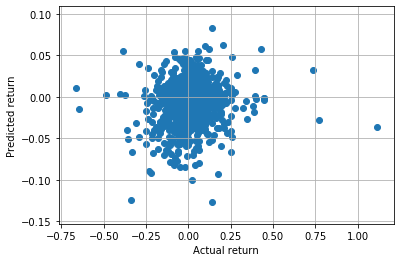

R2: -0.0073
RMSE: 0.1255


In [60]:
import keras
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
np.random.seed(42)
def regression_1():
    model = Sequential()
    model.add(Dense(32, kernel_initializer='random_normal', activation='selu', input_shape=(139,)))
    model.add(BatchNormalization())
    model.add(Dense(32, kernel_initializer='random_normal', activation='selu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation = 'linear'))
    return model

def training_block(x_train, y_train, x_test, model, run):
    weight_name = r'./yujia_{}.h5'.format(run)
    adam = keras.optimizers.Adam(lr=0.01)
    model.compile(loss='mae', optimizer= adam, metrics=['mae'])
    elstp = EarlyStopping(monitor='val_loss', min_delta=0, patience=200, verbose=0, mode='min')
    checkpoint = ModelCheckpoint(weight_name, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint,elstp]
    history = model.fit(x_train, y_train, epochs=20000, batch_size=len(y_train), validation_split=0.5, callbacks=callbacks_list, verbose=1)
    history_history = history.history
    model.load_weights(weight_name)
    model.compile(loss='mae', optimizer= adam, metrics=['mae'])
    y_pred = model.predict(x_test)
    return y_pred, history_history

def train(x, y, model):
    x_trains, x_tests, y_trains, y_tests = k_fold(x, y, n_splits=4)
    y_true = []
    y_pred = []
    histories = []
    for i in range(len(x_trains)):
        x_train = x_trains[i]
        x_test = x_tests[i]
        y_train = y_trains[i]*100
        y_test = y_tests[i]
        result = training_block(x_train, y_train, x_test, model, run=i)
        y_pred.append(result[0]/100)
        y_true.append(y_tests[i])
        histories.append(result[1])
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    # evaluation
    plot_pred(y_true, y_pred, 'neural network')
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**0.5
    print('R2: {:.4f}'.format(r2))
    print('RMSE: {:.4f}'.format(rmse))
    return histories

histories = train(x, y, model=regression_1())

In [ ]:
plt.plot(histories[0]['val_loss'])

Train on 97 samples, validate on 391 samples
Epoch 1/20000
97/97 [==============================] - 2s 23ms/step - loss: 1.6677 - mean_squared_error: 1.6677 - val_loss: 73.8025 - val_mean_squared_error: 73.8025
Epoch 2/20000
97/97 [==============================] - 0s 47us/step - loss: 1.0325 - mean_squared_error: 1.0325 - val_loss: 14.2131 - val_mean_squared_error: 14.2131
Epoch 3/20000
97/97 [==============================] - 0s 49us/step - loss: 0.4379 - mean_squared_error: 0.4379 - val_loss: 7.5748 - val_mean_squared_error: 7.5748
Epoch 4/20000
97/97 [==============================] - 0s 48us/step - loss: 0.2808 - mean_squared_error: 0.2808 - val_loss: 4.6363 - val_mean_squared_error: 4.6363
Epoch 5/20000
97/97 [==============================] - 0s 51us/step - loss: 0.2015 - mean_squared_error: 0.2015 - val_loss: 3.4756 - val_mean_squared_error: 3.4756
Epoch 6/20000
97/97 [==============================] - 0s 51us/step - loss: 0.1546 - mean_squared_error: 0.1546 - val_loss: 2.7990 

Epoch 51/20000
97/97 [==============================] - 0s 52us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.2571 - val_mean_squared_error: 0.2571
Epoch 52/20000
97/97 [==============================] - 0s 47us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.2524 - val_mean_squared_error: 0.2524
Epoch 53/20000
97/97 [==============================] - 0s 47us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.2480 - val_mean_squared_error: 0.2480
Epoch 54/20000
97/97 [==============================] - 0s 48us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.2441 - val_mean_squared_error: 0.2441
Epoch 55/20000
97/97 [==============================] - 0s 40us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.2409 - val_mean_squared_error: 0.2409
Epoch 56/20000
97/97 [==============================] - 0s 56us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.2386 - val_mean_squared_error: 0.2386
Epoch 57/2

Epoch 101/20000
97/97 [==============================] - 0s 50us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.2323 - val_mean_squared_error: 0.2323
Epoch 102/20000
97/97 [==============================] - 0s 49us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.2331 - val_mean_squared_error: 0.2331
Epoch 103/20000
97/97 [==============================] - 0s 46us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.2337 - val_mean_squared_error: 0.2337
Epoch 104/20000
97/97 [==============================] - 0s 46us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.2344 - val_mean_squared_error: 0.2344
Epoch 105/20000
97/97 [==============================] - 0s 49us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.2351 - val_mean_squared_error: 0.2351
Epoch 106/20000
97/97 [==============================] - 0s 45us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.2357 - val_mean_squared_error: 0.2357
Epoc

Epoch 151/20000
97/97 [==============================] - 0s 39us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.2621 - val_mean_squared_error: 0.2621
Epoch 152/20000
97/97 [==============================] - 0s 52us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.2632 - val_mean_squared_error: 0.2632
Epoch 153/20000
97/97 [==============================] - 0s 54us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.2640 - val_mean_squared_error: 0.2640
Epoch 154/20000
97/97 [==============================] - 0s 59us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.2647 - val_mean_squared_error: 0.2647
Epoch 155/20000
97/97 [==============================] - 0s 51us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.2653 - val_mean_squared_error: 0.2653
Epoch 156/20000
97/97 [==============================] - 0s 61us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.2660 - val_mean_squared_error: 0.2660
Epoc

Epoch 201/20000
97/97 [==============================] - 0s 56us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.2902 - val_mean_squared_error: 0.2902
Epoch 202/20000
97/97 [==============================] - 0s 44us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.2906 - val_mean_squared_error: 0.2906
Epoch 203/20000
97/97 [==============================] - 0s 54us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.2910 - val_mean_squared_error: 0.2910
Epoch 204/20000
97/97 [==============================] - 0s 56us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.2915 - val_mean_squared_error: 0.2915
Epoch 205/20000
97/97 [==============================] - 0s 42us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.2919 - val_mean_squared_error: 0.2919
Epoch 206/20000
97/97 [==============================] - 0s 56us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.2924 - val_mean_squared_error: 0.2924
Epoc

Epoch 251/20000
97/97 [==============================] - 0s 53us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.3016 - val_mean_squared_error: 0.3016
Epoch 252/20000
97/97 [==============================] - 0s 52us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.3018 - val_mean_squared_error: 0.3018
Epoch 253/20000
97/97 [==============================] - 0s 45us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.3021 - val_mean_squared_error: 0.3021
Epoch 254/20000
97/97 [==============================] - 0s 48us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.3024 - val_mean_squared_error: 0.3024
Epoch 255/20000
97/97 [==============================] - 0s 53us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.3026 - val_mean_squared_error: 0.3026
Epoch 256/20000
97/97 [==============================] - 0s 40us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.3028 - val_mean_squared_error: 0.3028
Epoc

Epoch 29/20000
97/97 [==============================] - 0s 50us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.2489 - val_mean_squared_error: 0.2489
Epoch 30/20000
97/97 [==============================] - 0s 62us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.2428 - val_mean_squared_error: 0.2428
Epoch 31/20000
97/97 [==============================] - 0s 47us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.2345 - val_mean_squared_error: 0.2345
Epoch 32/20000
97/97 [==============================] - 0s 51us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.2258 - val_mean_squared_error: 0.2258
Epoch 33/20000
97/97 [==============================] - 0s 44us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.2180 - val_mean_squared_error: 0.2180
Epoch 34/20000
97/97 [==============================] - 0s 52us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.2119 - val_mean_squared_error: 0.2119
Epoch 35/2

Epoch 79/20000
97/97 [==============================] - 0s 44us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.1491 - val_mean_squared_error: 0.1491
Epoch 80/20000
97/97 [==============================] - 0s 78us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.1479 - val_mean_squared_error: 0.1479
Epoch 81/20000
97/97 [==============================] - 0s 52us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.1468 - val_mean_squared_error: 0.1468
Epoch 82/20000
97/97 [==============================] - 0s 45us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.1459 - val_mean_squared_error: 0.1459
Epoch 83/20000
97/97 [==============================] - 0s 59us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.1451 - val_mean_squared_error: 0.1451
Epoch 84/20000
97/97 [==============================] - 0s 46us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.1444 - val_mean_squared_error: 0.1444
Epoch 85/2

Epoch 129/20000
97/97 [==============================] - 0s 44us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.1216 - val_mean_squared_error: 0.1216
Epoch 130/20000
97/97 [==============================] - 0s 50us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.1214 - val_mean_squared_error: 0.1214
Epoch 131/20000
97/97 [==============================] - 0s 51us/step - loss: 9.9633e-04 - mean_squared_error: 9.9633e-04 - val_loss: 0.1213 - val_mean_squared_error: 0.1213
Epoch 132/20000
97/97 [==============================] - 0s 45us/step - loss: 9.9011e-04 - mean_squared_error: 9.9011e-04 - val_loss: 0.1212 - val_mean_squared_error: 0.1212
Epoch 133/20000
97/97 [==============================] - 0s 56us/step - loss: 9.8216e-04 - mean_squared_error: 9.8216e-04 - val_loss: 0.1212 - val_mean_squared_error: 0.1212
Epoch 134/20000
97/97 [==============================] - 0s 42us/step - loss: 9.7677e-04 - mean_squared_error: 9.7677e-04 - val_loss: 0.1213 - val

Epoch 177/20000
97/97 [==============================] - 0s 51us/step - loss: 7.1117e-04 - mean_squared_error: 7.1117e-04 - val_loss: 0.1239 - val_mean_squared_error: 0.1239
Epoch 178/20000
97/97 [==============================] - 0s 41us/step - loss: 7.0577e-04 - mean_squared_error: 7.0577e-04 - val_loss: 0.1240 - val_mean_squared_error: 0.1240
Epoch 179/20000
97/97 [==============================] - 0s 36us/step - loss: 7.0028e-04 - mean_squared_error: 7.0028e-04 - val_loss: 0.1242 - val_mean_squared_error: 0.1242
Epoch 180/20000
97/97 [==============================] - 0s 43us/step - loss: 6.9432e-04 - mean_squared_error: 6.9432e-04 - val_loss: 0.1244 - val_mean_squared_error: 0.1244
Epoch 181/20000
97/97 [==============================] - 0s 48us/step - loss: 6.8893e-04 - mean_squared_error: 6.8893e-04 - val_loss: 0.1245 - val_mean_squared_error: 0.1245
Epoch 182/20000
97/97 [==============================] - 0s 41us/step - loss: 6.8337e-04 - mean_squared_error: 6.8337e-04 - val_lo

Epoch 225/20000
97/97 [==============================] - 0s 39us/step - loss: 4.0144e-04 - mean_squared_error: 4.0144e-04 - val_loss: 0.1359 - val_mean_squared_error: 0.1359
Epoch 226/20000
97/97 [==============================] - 0s 56us/step - loss: 3.9648e-04 - mean_squared_error: 3.9648e-04 - val_loss: 0.1357 - val_mean_squared_error: 0.1357
Epoch 227/20000
97/97 [==============================] - 0s 49us/step - loss: 3.9144e-04 - mean_squared_error: 3.9144e-04 - val_loss: 0.1358 - val_mean_squared_error: 0.1358
Epoch 228/20000
97/97 [==============================] - 0s 46us/step - loss: 3.8657e-04 - mean_squared_error: 3.8657e-04 - val_loss: 0.1361 - val_mean_squared_error: 0.1361
Epoch 229/20000
97/97 [==============================] - 0s 46us/step - loss: 3.8099e-04 - mean_squared_error: 3.8099e-04 - val_loss: 0.1364 - val_mean_squared_error: 0.1364
Epoch 230/20000
97/97 [==============================] - 0s 57us/step - loss: 3.7558e-04 - mean_squared_error: 3.7558e-04 - val_lo

97/97 [==============================] - 0s 59us/step - loss: 2.1532e-04 - mean_squared_error: 2.1532e-04 - val_loss: 0.1526 - val_mean_squared_error: 0.1526
Epoch 273/20000
97/97 [==============================] - 0s 53us/step - loss: 2.1187e-04 - mean_squared_error: 2.1187e-04 - val_loss: 0.1525 - val_mean_squared_error: 0.1525
Epoch 274/20000
97/97 [==============================] - 0s 50us/step - loss: 2.1003e-04 - mean_squared_error: 2.1003e-04 - val_loss: 0.1529 - val_mean_squared_error: 0.1529
Epoch 275/20000
97/97 [==============================] - 0s 57us/step - loss: 2.0705e-04 - mean_squared_error: 2.0705e-04 - val_loss: 0.1529 - val_mean_squared_error: 0.1529
Epoch 276/20000
97/97 [==============================] - 0s 45us/step - loss: 2.0386e-04 - mean_squared_error: 2.0386e-04 - val_loss: 0.1529 - val_mean_squared_error: 0.1529
Epoch 277/20000
97/97 [==============================] - 0s 45us/step - loss: 2.0138e-04 - mean_squared_error: 2.0138e-04 - val_loss: 0.1533 - val

Epoch 320/20000
97/97 [==============================] - 0s 60us/step - loss: 1.2456e-04 - mean_squared_error: 1.2456e-04 - val_loss: 0.1597 - val_mean_squared_error: 0.1597
Epoch 321/20000
97/97 [==============================] - 0s 45us/step - loss: 1.2333e-04 - mean_squared_error: 1.2333e-04 - val_loss: 0.1599 - val_mean_squared_error: 0.1599
Epoch 322/20000
97/97 [==============================] - 0s 49us/step - loss: 1.2241e-04 - mean_squared_error: 1.2241e-04 - val_loss: 0.1600 - val_mean_squared_error: 0.1600
Epoch 323/20000
97/97 [==============================] - 0s 45us/step - loss: 1.2111e-04 - mean_squared_error: 1.2111e-04 - val_loss: 0.1602 - val_mean_squared_error: 0.1602
Epoch 324/20000
97/97 [==============================] - 0s 51us/step - loss: 1.2024e-04 - mean_squared_error: 1.2024e-04 - val_loss: 0.1603 - val_mean_squared_error: 0.1603
Epoch 325/20000
97/97 [==============================] - 0s 46us/step - loss: 1.1916e-04 - mean_squared_error: 1.1916e-04 - val_lo

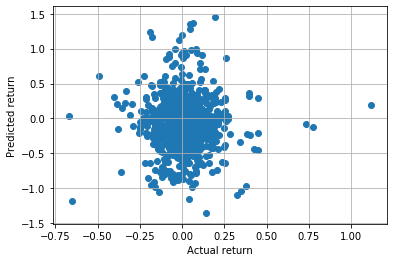

R2: -8.5722
RMSE: 0.3869


[{'val_loss': [73.8024673461914,
   14.213116645812988,
   7.574809551239014,
   4.636319637298584,
   3.475635051727295,
   2.7989866733551025,
   2.352386713027954,
   2.1694095134735107,
   2.1625313758850098,
   2.2209742069244385,
   2.3000645637512207,
   2.322368621826172,
   2.229682207107544,
   2.0368754863739014,
   1.7801594734191895,
   1.5129776000976562,
   1.2925529479980469,
   1.1265885829925537,
   1.0078121423721313,
   0.9221805930137634,
   0.8611730337142944,
   0.8128402829170227,
   0.7654332518577576,
   0.7167364358901978,
   0.6652739644050598,
   0.6130167245864868,
   0.5620523691177368,
   0.5165700912475586,
   0.4733419120311737,
   0.43763968348503113,
   0.40887880325317383,
   0.3858397901058197,
   0.36763647198677063,
   0.3531588613986969,
   0.34132546186447144,
   0.33125317096710205,
   0.32245150208473206,
   0.314879447221756,
   0.3079177141189575,
   0.3011826276779175,
   0.29497548937797546,
   0.288882315158844,
   0.2837558090686798,
  

In [55]:
def regression_2():
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(111,)))
    model.add(BatchNormalization())
    model.add(Dense(16, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation = 'linear'))
    return model

train(x_vt, y, model=regression_2())

In [ ]:
def regression_3():
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(90,)))
    model.add(BatchNormalization())
    model.add(Dense(16, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation = 'linear'))
    return model

train(x_rfe, y, model=regression_3())

In [ ]:
def regression_4():
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(10,)))
    model.add(BatchNormalization())
    model.add(Dense(16, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation = 'linear'))
    return model

train(x_pca, y, model=regression_4())